In [1]:
import hyperopt
print("hyperopt.__version__", hyperopt.__version__)
import sklearn
print("sklearn.__version__", sklearn.__version__)
#pip install scikit-learn==1.0.2  다운그레이드 해서 테스트하기
import pandas
print("pandas.__version__", pandas.__version__)
#pip install pandas==1.3.5
import xgboost
print("xgboost.__version__", xgboost.__version__)

hyperopt.__version__ 0.2.7
sklearn.__version__ 1.0.2
pandas.__version__ 1.3.5
xgboost.__version__ 1.5.0


In [2]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [3]:

lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)],
                 voting='soft' # mean
                 )                                            

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=0)

In [4]:
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
accuracy_score(y_test, pred)

0.956140350877193

In [8]:
# 개별 분류기의 예측 성능 -LR
lr_clf_1 = LogisticRegression(solver='liblinear')
lr_clf_1.fit(X_train, y_train)
pred = lr_clf_1.predict(X_test)
accuracy_score(y_test, pred)

0.956140350877193

In [9]:
# 개별 분류기의 예측 성능 -KNN
knn_clf_1 = KNeighborsClassifier(n_neighbors=8)
knn_clf_1.fit(X_train, y_train)
pred = knn_clf_1.predict(X_test)
accuracy_score(y_test, pred)

c:\Users\Hyeonji Kim\.conda\envs\xgboost_env\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.9473684210526315

### 랜덤 포레스트

In [11]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [15]:
import pandas as pd

def get_human_dataset( ):

    feature_name_df = pd.read_csv('./data/UCI HAR Dataset/features.txt', sep='\s+', 
                                header=None,names=['column_index','column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/UCI HAR Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/UCI HAR Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/UCI HAR Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/UCI HAR Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [16]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy_score(y_test, pred)

C:\Users\Hyeonji Kim\AppData\Local\Temp\ipykernel_18668\1416478491.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train, y_train)


0.9195792331184255

In [19]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8,16,24], 
    'min_samples_split' : [2,8,16],
    'min_samples_leaf' : [1,6,12]
}

# n_jobs=-1 > 병렬처리
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)


c:\Users\Hyeonji Kim\.conda\envs\xgboost_env\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [8, 16, 24],
                         'min_samples_leaf': [1, 6, 12],
                         'min_samples_split': [2, 8, 16]})

In [21]:
print(grid_cv.best_params_)
print(grid_cv.best_score_)
accuracy_score(y_test, pred)

{'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
0.9164853101196953


0.9195792331184255

In [22]:
best_model = grid_cv.best_estimator_

best_pred = best_model.predict(X_test)

accuracy_score(y_test, best_pred)

0.9260264675941635

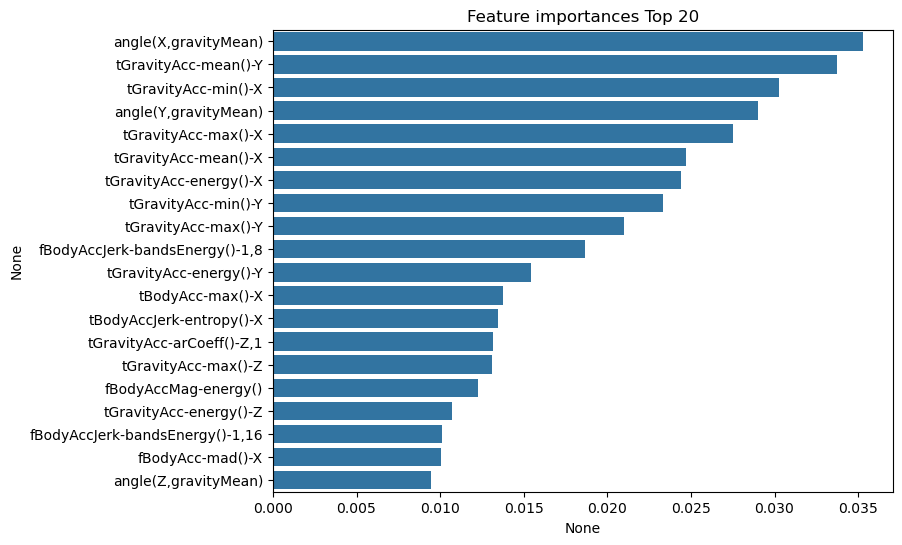

In [24]:
# 피처 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_value = best_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_value, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### Gradient Boosting Machine(GBM)

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
import time

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time() # 수행시간 측정

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)

print(accuracy_score(y_test, gb_pred))
print(f'GBM 수행시간: {time.time()-start_time}')



c:\Users\Hyeonji Kim\.conda\envs\xgboost_env\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9389209365456397
GBM 수행시간: 585.8318798542023
